In [1]:
import os
import math
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer

from numpy import load

from xgboost import XGBClassifier

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

# Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_semestr_1_personal.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

# Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   studium_id              4546 non-null   int64  
 1   dokoncil_semestr        4546 non-null   float64
 2   pohlavi_kod             4546 non-null   int64  
 3   je_cech                 4546 non-null   int64  
 4   datum_zahajeni          4546 non-null   int64  
 5   rok_maturity            4546 non-null   int64  
 6   maturita_nastup_rozdil  4546 non-null   int64  
 7   gymnazium               4546 non-null   int64  
 8   praha                   4546 non-null   int64  
 9   scio                    4546 non-null   int64  
 10  olym                    4546 non-null   int64  
 11  zkouska                 4546 non-null   int64  
 12  prominuti               4546 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 461.8 KB


In [4]:
matrix_bak.mean()

studium_id                1.491477e+07
dokoncil_semestr          5.343159e-01
pohlavi_kod               1.291245e-01
je_cech                   7.617686e-01
datum_zahajeni            2.017447e+03
rok_maturity              2.016688e+03
maturita_nastup_rozdil    7.591289e-01
gymnazium                 5.547734e-01
praha                     3.893533e-02
scio                      1.135064e-01
olym                      1.223053e-01
zkouska                   4.179498e-02
prominuti                 0.000000e+00
dtype: float64

# Příprava datasetu

## Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

## Nastavení atributů na kategorické

In [6]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
# pohlavi_kod
matrix_bak['pohlavi_kod'] = matrix_bak['pohlavi_kod'].astype(attr_category)
# scio
matrix_bak['scio'] = matrix_bak['scio'].astype(attr_category)
# olym
matrix_bak['olym'] = matrix_bak['olym'].astype(attr_category)
# zkouska
matrix_bak['zkouska'] = matrix_bak['zkouska'].astype(attr_category)
# prominuti
matrix_bak['prominuti'] = matrix_bak['prominuti'].astype(attr_category)

In [7]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[-1, 0, 1], ordered=False)
# je_cech
matrix_bak['je_cech'] = matrix_bak['je_cech'].astype(attr_category)
# gymnazium
matrix_bak['gymnazium'] = matrix_bak['gymnazium'].astype(attr_category)
# praha
matrix_bak['praha'] = matrix_bak['praha'].astype(attr_category)

In [8]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 11736906 to 11740806
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   dokoncil_semestr        4546 non-null   float64 
 1   pohlavi_kod             4546 non-null   category
 2   je_cech                 4546 non-null   category
 3   datum_zahajeni          4546 non-null   int64   
 4   rok_maturity            4546 non-null   int64   
 5   maturita_nastup_rozdil  4546 non-null   int64   
 6   gymnazium               4546 non-null   category
 7   praha                   4546 non-null   category
 8   scio                    4546 non-null   category
 9   olym                    4546 non-null   category
 10  zkouska                 4546 non-null   category
 11  prominuti               4546 non-null   category
dtypes: category(8), float64(1), int64(3)
memory usage: 213.9 KB


# Modelování

## Rozdělení datasetu

In [9]:
Xdata = matrix_bak.drop(columns='dokoncil_semestr')
ydata = matrix_bak.dokoncil_semestr

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print()
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print()
print("rozložení hodnot")
display(ydata.value_counts())
display(ytrain.value_counts(normalize=True))
print()
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print()
print("rozložení hodnot")
display(ytrain.value_counts())
display(ytrain.value_counts(normalize=True))
print()
print("testovací data")
display(Xtest.shape)
display(ytest.shape)
print()
print("rozložení hodnot")
display(ytest.value_counts())
display(ytest.value_counts(normalize=True))


původní data


(4546, 11)

(4546,)


rozložení hodnot


1.0    2429
0.0    2117
Name: dokoncil_semestr, dtype: int64

1.0    0.534378
0.0    0.465622
Name: dokoncil_semestr, dtype: float64


trénovací data


(3636, 11)

(3636,)


rozložení hodnot


1.0    1943
0.0    1693
Name: dokoncil_semestr, dtype: int64

1.0    0.534378
0.0    0.465622
Name: dokoncil_semestr, dtype: float64


testovací data


(910, 11)

(910,)


rozložení hodnot


1.0    486
0.0    424
Name: dokoncil_semestr, dtype: int64

1.0    0.534066
0.0    0.465934
Name: dokoncil_semestr, dtype: float64

## Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [11]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

## Rozhodovací strom

In [12]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [13]:
dt = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}

0.663077 (+/-0.024530) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.641268 (+/-0.013434) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.645973 (+/-0.044318) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.665489 (+/-0.035800) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.659342 (+/-0.033907) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.663077 (+/-0.024530) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.641268 (+/-0.013434) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.645973 (+/-0.044318) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.665894 (+/-0.036705) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.659607 (+/-0.034584) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



### Výsledky modelu na trénovacím a testovacím datasetu

In [14]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.582233
accuracy score (test): 0.524176


### Důležitost jednotlivých příznaků

In [15]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
3,rok_maturity,0.355005
4,maturita_nastup_rozdil,0.193848
5,gymnazium,0.128783
2,datum_zahajeni,0.079438
9,zkouska,0.067639
1,je_cech,0.060348
6,praha,0.048292
0,pohlavi_kod,0.035137
8,olym,0.031509
7,scio,0.000000


### Vytvořený Rozhodovací strom

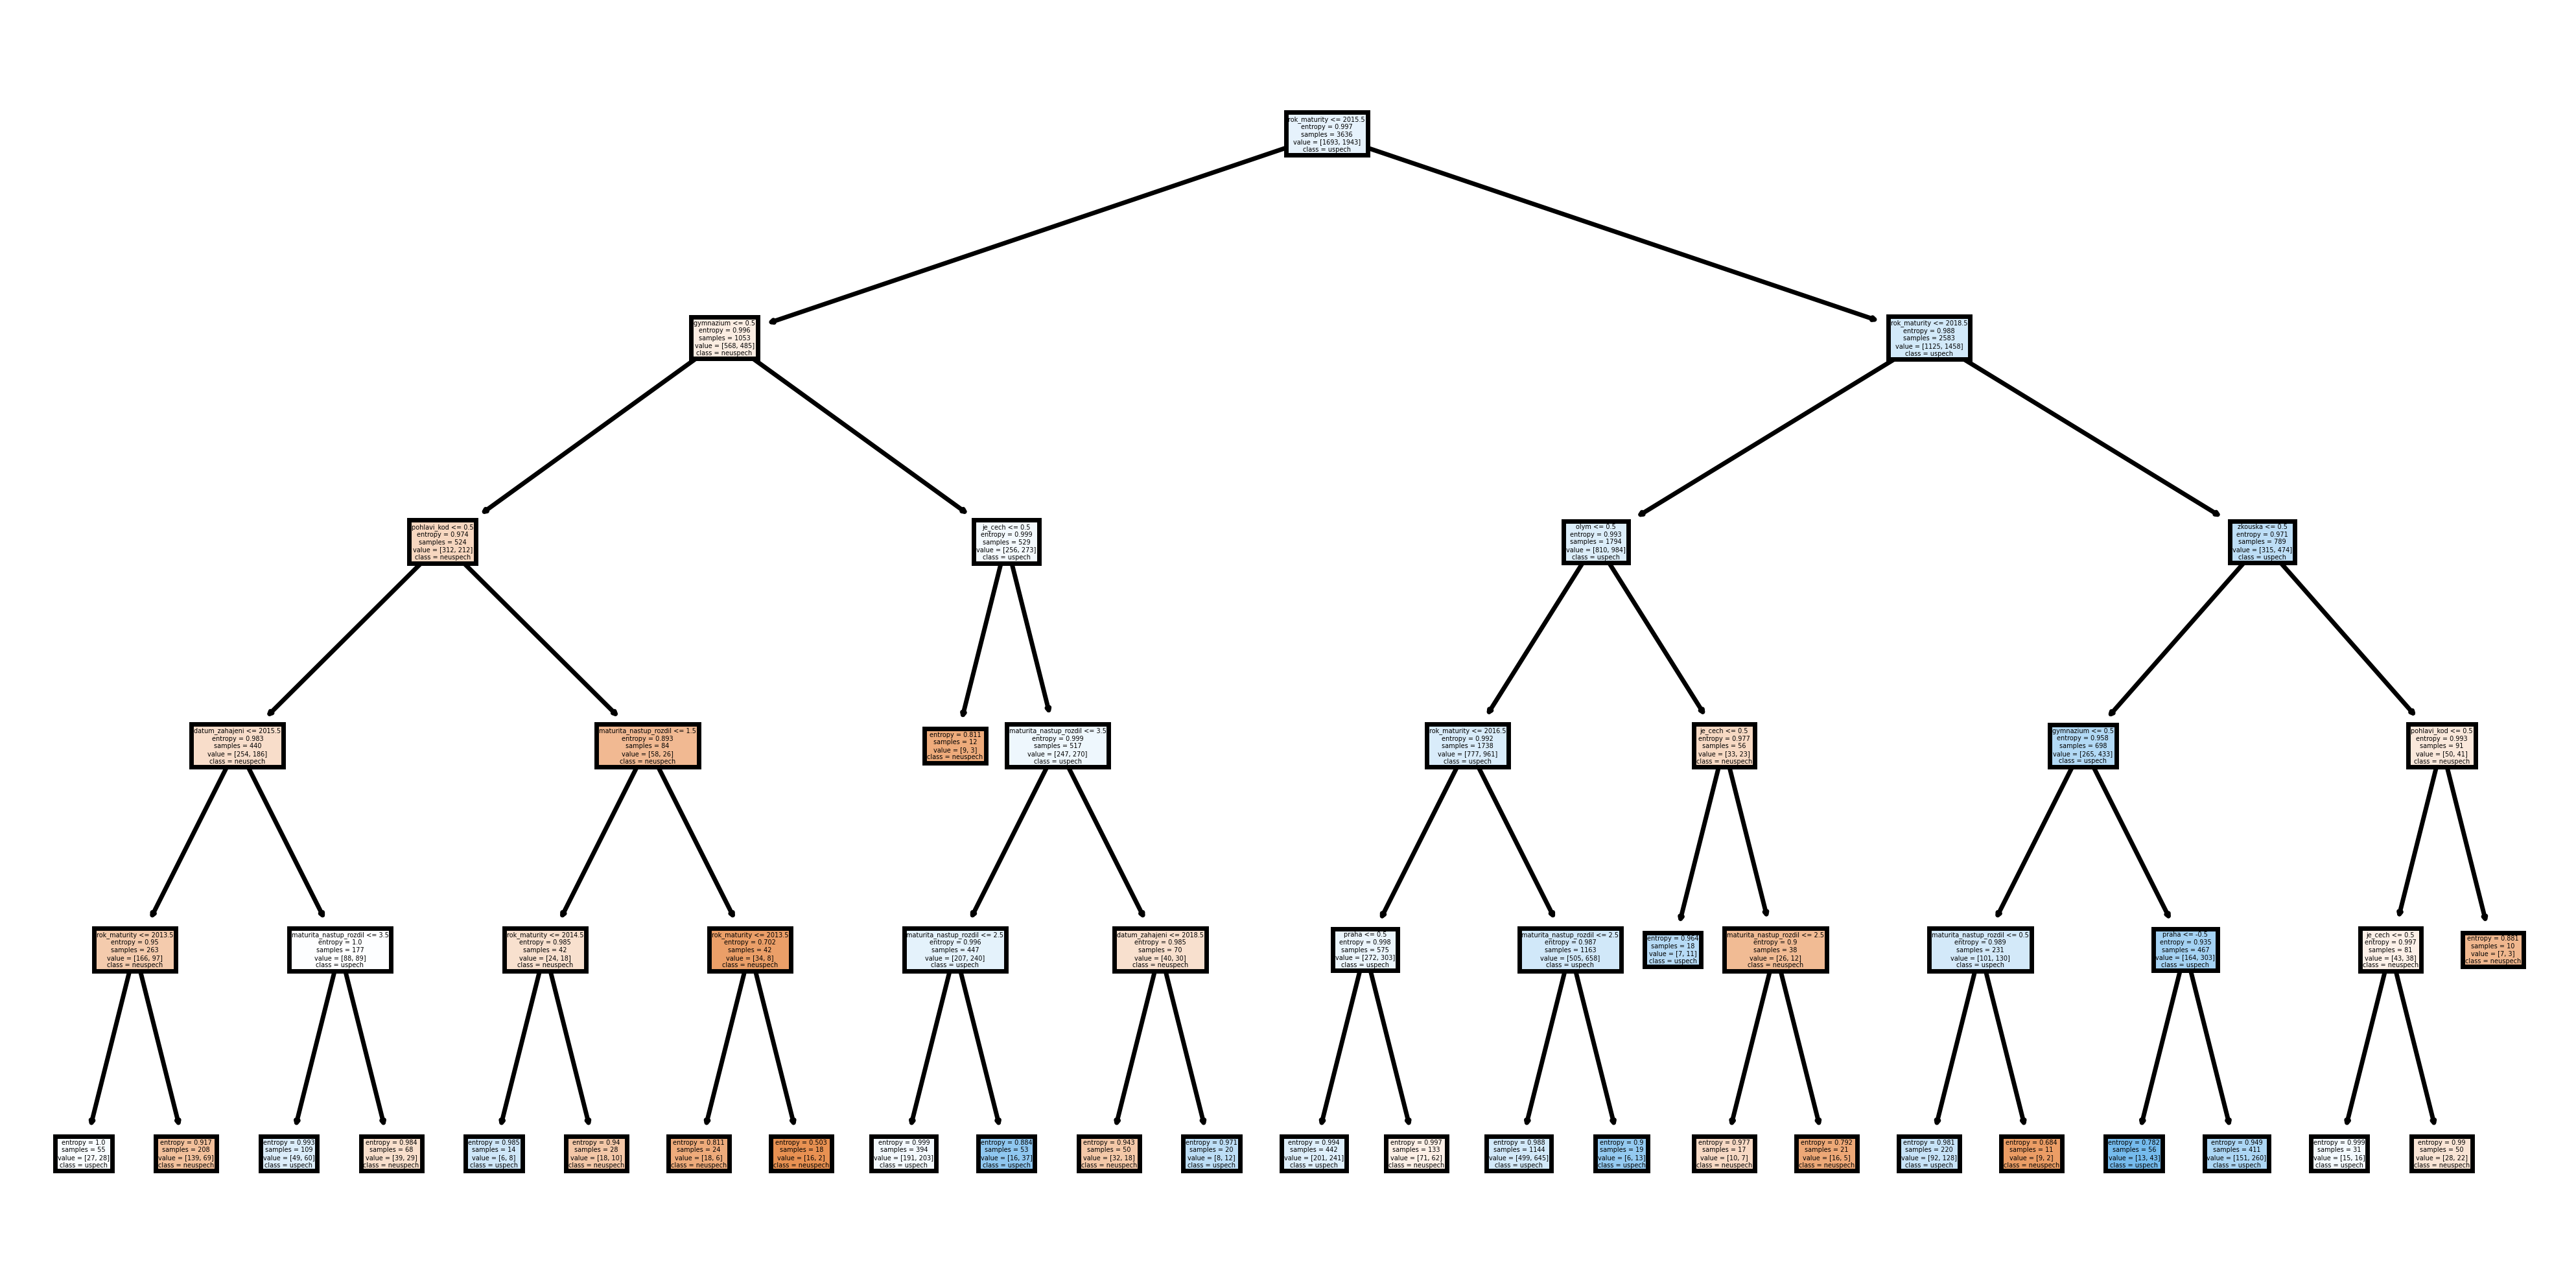

In [16]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
path_file = os.sep.join(['decision_trees', 'tree_f1_semestr1.png'])
fig.savefig(path_file)

## Random forest

In [17]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [18]:
rf = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 10}

0.666478 (+/-0.028937) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.668823 (+/-0.028755) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.659824 (+/-0.023764) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.662927 (+/-0.032503) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.663623 (+/-0.038679) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.664899 (+/-0.034056) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.660588 (+/-0.033393) for {'criterion': 'gini', 'max_depth': 2, 

### Výsledky modelu na trénovacím a testovacím datasetu

In [19]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf.predict(Xtest))))

accuracy score (train): 0.563806
accuracy score (test): 0.561538


### Důležitost jednotlivých příznaků

In [20]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
2,datum_zahajeni,0.286707
3,rok_maturity,0.235148
5,gymnazium,0.210739
4,maturita_nastup_rozdil,0.132495
1,je_cech,0.044662
9,zkouska,0.031449
0,pohlavi_kod,0.025003
8,olym,0.020475
6,praha,0.013323
7,scio,0.000000


## Adaboost

In [21]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [22]:
ab = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.2, 'n_estimators': 15}

0.652137 (+/-0.031959) for {'learning_rate': 0.1, 'n_estimators': 5}
0.652063 (+/-0.026612) for {'learning_rate': 0.1, 'n_estimators': 10}
0.661761 (+/-0.030466) for {'learning_rate': 0.1, 'n_estimators': 15}
0.660693 (+/-0.032723) for {'learning_rate': 0.1, 'n_estimators': 20}
0.661530 (+/-0.029171) for {'learning_rate': 0.1, 'n_estimators': 25}
0.657641 (+/-0.023630) for {'learning_rate': 0.1, 'n_estimators': 30}
0.660030 (+/-0.031121) for {'learning_rate': 0.1, 'n_estimators': 35}
0.660884 (+/-0.030744) for {'learning_rate': 0.1, 'n_estimators': 40}
0.659822 (+/-0.029507) for {'learning_rate': 0.1, 'n_estimators': 45}
0.659616 (+/-0.016244) for {'learning_rate': 0.2, 'n_estimators': 5}
0.662056 (+/-0.030403) for {'learning_rate': 0.2, 'n_estimators': 10}
0.663575 (+/-0.029285) for {'learning_rate': 0.2, 'n_estimators': 15}
0.661166 (+/-0.030380) for {'learning_rate': 0.2, 'n_estimators': 20}
0.658093 (+/-0.02120

### Výsledky modelu na trénovacím a testovacím datasetu

In [23]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab.predict(Xtest))))

accuracy score (train): 0.563806
accuracy score (test): 0.568132


### Důležitost jednotlivých příznaků

In [24]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
3,rok_maturity,0.333333
2,datum_zahajeni,0.266667
5,gymnazium,0.266667
4,maturita_nastup_rozdil,0.133333
0,pohlavi_kod,0.000000
1,je_cech,0.000000
6,praha,0.000000
7,scio,0.000000
8,olym,0.000000
9,zkouska,0.000000


## Xgboost

In [25]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [26]:
xgb = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 3}

0.653710 (+/-0.019729) for {'eta': 0.1, 'max_depth': 3}
0.645312 (+/-0.011479) for {'eta': 0.1, 'max_depth': 4}
0.648454 (+/-0.023415) for {'eta': 0.1, 'max_depth': 5}
0.644654 (+/-0.022477) for {'eta': 0.1, 'max_depth': 6}
0.640906 (+/-0.028875) for {'eta': 0.1, 'max_depth': 7}
0.647031 (+/-0.022864) for {'eta': 0.2, 'max_depth': 3}
0.641385 (+/-0.013649) for {'eta': 0.2, 'max_depth': 4}
0.636954 (+/-0.015313) for {'eta': 0.2, 'max_depth': 5}
0.633289 (+/-0.018284) for {'eta': 0.2, 'max_depth': 6}
0.631613 (+/-0.014450) for {'eta': 0.2, 'max_depth': 7}
0.637326 (+/-0.024565) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.640489 (+/-0.018479) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.639068 (+/-0.011887) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.632633 (+/-0.015502) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.628008 (+/-0.017392) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.638564 (+/-0.021397)

### Výsledky modelu na trénovacím a testovacím datasetu

In [27]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb.predict(Xtest))))

accuracy score XGBoost (train): 0.595710
accuracy score XGBoost (val): 0.551648


### Důležitost jednotlivých příznaků

In [28]:
feat_imp = pd.Series(xgb.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [29]:
feat_imp

maturita_nastup_rozdil    148.0
rok_maturity              124.0
datum_zahajeni             80.0
praha                      64.0
gymnazium                  52.0
pohlavi_kod                43.0
scio                       34.0
je_cech                    34.0
olym                       31.0
zkouska                    25.0
dtype: float64

## MLP

In [30]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

### Výsledky modelu na trénovacím a testovacím datasetu

In [31]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.475798
accuracy score mlp (val): 0.463736


## kNN

In [32]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [33]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

0.547231 (+/-0.042035) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.547231 (+/-0.042035) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.547628 (+/-0.041904) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.547628 (+/-0.041904) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.352534 (+/-0.061457) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.363468 (+/-0.059883) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.352134 (+/-0.060050) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.364485 (+/-0.060762) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.563483 (+/-0.071439) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.557862 (+/-0.074789) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.563202 (+/-0.072048) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.557430 (+/-0.077321) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.45

### Výsledky modelu na trénovacím a testovacím datasetu

In [34]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.602035
accuracy score knn (val): 0.518681


# Výsledky

In [35]:
results = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

results.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt.predict(Xtest)), 3)
results.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf.predict(Xtest)), 3)
results.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab.predict(Xtest)), 3)
results.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb.predict(Xtest)), 3)
results.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

### Výsledky zobrazené grafem

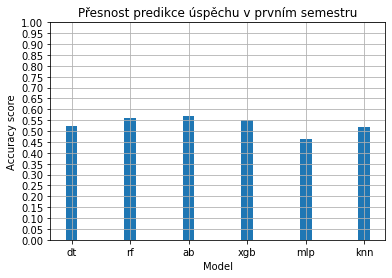

In [36]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results.index, results['vysledky'].values, width)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v prvním semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

### Výsledky zobrazené tabulkou

In [37]:
results

,vysledky
dt,0.524
rf,0.562
ab,0.568
xgb,0.552
mlp,0.464
knn,0.519
